In [1]:
import pprint

import numpy as np
from Crypto.Random.random import getrandbits

# Prerequisites
-  Block ciphers design

In [2]:
def get_bit(x: int, i: int, n: int) -> int:
    """
    Gets the ith bit of an n-bit number
    n_bits = 5
    x = 0 1 0 1 0
    i = 0 1 2 3 4
    """
    return (x >> (n - 1 - i)) & 1


def set_bit(x: int, i: int, n: int, b: int) -> int:
    """
    sets the `i`th bit to `b` of an n_bits-bit numebr
    """
    if b == 1:
        return x | (1 << (n - 1 - i))
    else:
        return x & ~int((1 << (n - 1 - i)))


def inverse_sbox(S: list) -> list:
    """
    Input:
    S: {list} -- sbox
    Return
    {list} -- the inverse of the sbox
    """
    S_ = [-1] * len(S)
    for i, entry in enumerate(S):
        S_[entry] = i
    return S_

# Theory

For this page we denote the following

- $M$ is a message
- $C$ is a ciphertext
- $K$ is a key
- greek letters for masks

Sometimes we will denote
- $X$ - Sbox input
- $Y$ - Sbox output

*Idea*
- We have a message $M$. We change some bits in it. We try to predict the change in ciphertext
- The idea is that for each possible input difference of 2 inputs $(M, M')$the output difference of $(C, C')$ should be equally likely. Differential cryptanalysis exploits the fact that it isn't

Attack goals
- Key recovery
- Collision

## Differences

**Difference - Definition**  
Given the bit strings $X$ and $X'$ the difference between them will be denoted with $\Delta X = X \oplus X'$. 

Notation: We denote the input difference with $\Delta in$ and the output with $\Delta out$

*Main idea*:
- We will want to look at the relation between some $\Delta in$ and some $\Delta out$. Therefore we want to track the differences.  

Therefore differential cryptanalysis is a *chosen plaintext attack* because we will choose some input $X$ and some difference $\Delta X$ and compute our second input $X' = X \oplus \Delta X$

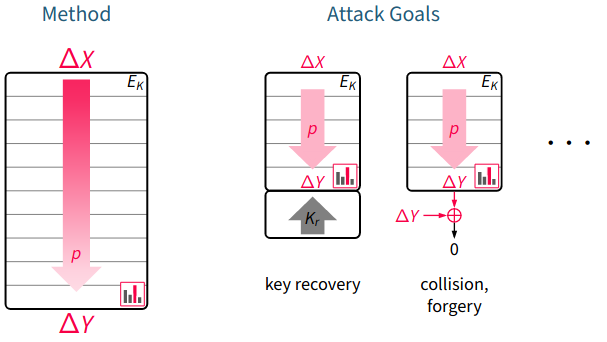

Now let's look at some possible cases

**An Sbox $S \Rightarrow Y = S[X]$**

Let $X, X', \Delta X$ be 2 inputs and the difference between them. Then $$\Delta Y = Y \oplus Y' = S[X] \oplus S[X'] = S[X] \oplus S[X \oplus \Delta X]$$

**The difference distribution table - Definition**  
For all input differences $\Delta X$ and all output differences $\Delta Y$ we can make a table which counts the frequency of an output difference for all inputs pairs $(X, X' = X \oplus \Delta X)$
- An entry $(\Delta X, \Delta Y)$ counts the number of input pairs $(X, X' = X \oplus \Delta X)$ that give $\Delta Y$
- The entry is also called a **characteristic** across an sbox $S$

**Remark**
- Knowing the differences $(\Delta X, \Delta Y)$ tells us something about the value
    - Not all values can produce these differences
    - Only a subset of *solutions*: $\{X \ : \ S(X \oplus \Delta X) \oplus S(X) = \delta Y\}$
    
    

**The propagation ratio - Definition**  
If we divide by the possible outputs we can represent the **propagation ratio** (probability):
$$Pr[\Delta out = \Delta Y | \Delta in = \Delta X] = \dfrac {DDT(\Delta X, \Delta Y)} {2^l}$$
- where $l$ = output size

**Properties**
- Sum of elements in a row is the number of possible inputs
- Sum of elements in a column is the number of possible outputs
- All elements are even
- $\Delta X = 0 \Rightarrow \Delta Y = 0$ for one-to-one S-boxes

**The ideal S-box** => all elements in DDT = 1

In [26]:
S = [0x2, 0x0, 0x4, 0x3, 0x9, 0x5, 0x6, 0x7, 0x1, 0xD, 0xE, 0xF, 0xA, 0x8, 0xC, 0xB]

In [27]:
def difference_distribution_table(S: list, l: int = 4) -> list[list[int]]:
    """
    Calculate the difference distribution table of an Sbox S with an input / output size of l
    """

    # A l**2 x l**2 table filled with 0
    res = [[0] * l**2 for _ in range(l**2)]

    # for each possible difference
    for delta_x in range(l**2):
        # for each possible input x
        for x in range(l**2):
            x_ = x ^ delta_x  # compute a possible x
            delta_y = S[x] ^ S[x_]  # compute a possible delta_y
            res[delta_x][delta_y] += 1  # increment that possibility
    return res

In [28]:
ddt = difference_distribution_table(S)
print(np.matrix(ddt))

[[16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4  4  0  0  0  0  4  0  0  0  0  4  0  0  0]
 [ 0  0  4  4  0  0  4  0  0  0  0  0  0  0  0  4]
 [ 0  4  0  4  4  0  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  4  0  4  4  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  4  0  4  0  4  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  4  4  0  0  0  0  0  4  0  0]
 [ 0  4  0  0  0  4  4  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  4  0  4  4  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  0  4  0  4  0  4]
 [ 0  0  0  0  0  4  0  0  0  0  0  0  4  0  4  4]
 [ 0  0  4  0  0  0  0  0  0  4  0  0  0  4  4  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  4  4  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  4  0  0  4  4  0  0  4  0]
 [ 0  0  0  0  0  0  4  0  0  4  0  4  4  0  0  0]]


In [6]:
# An interesting value  is ddt[c][8] = 16
print(ddt[0xC][8])

# All diff = 8
print(all([S[x] ^ S[x ^ 0xC] == 8 for x in range(1 << 4)]))

16
True


## Adding the key

**Influence of the key**
- Adding the key does **not** change the difference. This is because the `xor` cancels the key out
$$X \oplus K \oplus X' \oplus K = X \oplus X' = \Delta X$$

**Linear functions**  
If $f:\mathbb{F}_2 \to \mathbb{F}_2$ is an affine function $f(x) = \underbrace{l(x)}_{\text{linear part}} \oplus c$ where $c =$ constant then 
$$\Delta Y = \Delta f(\Delta X) = l(\Delta X)$$

Let's work through this example from "The block cipher companion"

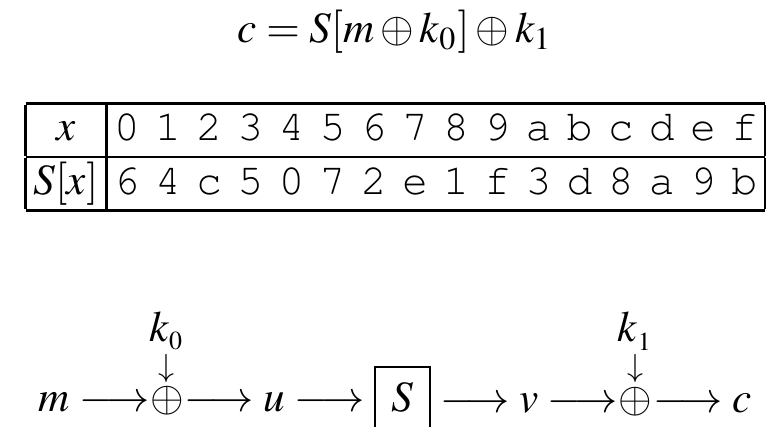

Consider a pair $(m_0, m_1)$:
$
u_0 = m_0 \oplus k_0 \\
v_0 = S[u_0] \\
c_0 = v_0 \oplus k_1 \\
$

$
u_1 = m_1 \oplus k_0 \\
v_1 = S[u_1] \\
c_1 = v_1 \oplus k_1 \\
$
Then we have
$$u_0 \oplus u_1 =  m_0 \oplus k_0 \oplus m_1 \oplus k_0 = m_0 \oplus m_1 = \Delta m$$

And
$$u_0 \oplus u_1 = S^{-1}[v_0] \oplus S^{-1}[v_1]$$

In [23]:
def cipher_one(m: int, k0: int, k1: int, S: list) -> int:
    u = m ^ k0
    v = S[u]
    c = v ^ k1
    return c

In [14]:
S = [6, 4, 0xC, 5, 0, 7, 2, 0xE, 1, 0xF, 3, 0xD, 8, 0xA, 9, 0xB]
S_ = inverse_sbox(S)

ddt = difference_distribution_table(S)
print(np.matrix(ddt))

[[16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  2  0  2  0  0  2  0  4  0]
 [ 0  6  6  0  0  0  0  0  0  2  2  0  0  0  0  0]
 [ 0  0  0  6  0  2  0  0  2  0  0  0  4  0  2  0]
 [ 0  0  0  2  0  2  4  0  0  2  2  2  0  0  2  0]
 [ 0  2  2  0  4  0  0  4  2  0  0  2  0  0  0  0]
 [ 0  0  2  0  4  0  0  2  2  0  2  2  2  0  0  0]
 [ 0  0  0  0  0  4  4  0  2  2  2  2  0  0  0  0]
 [ 0  0  0  0  0  2  0  2  4  0  0  4  0  2  0  2]
 [ 0  2  0  0  0  2  2  2  0  4  2  0  0  0  0  2]
 [ 0  0  0  0  2  2  0  0  0  4  4  0  2  2  0  0]
 [ 0  0  0  2  2  0  2  2  2  0  0  4  0  0  2  0]
 [ 0  4  0  2  0  2  0  0  2  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  2  2  0  0  0  0  6  2  0  4]
 [ 0  2  0  4  2  0  0  0  0  0  2  0  0  0  0  6]
 [ 0  0  0  0  2  0  2  0  0  0  0  0  0 10  0  2]]


0.625

In [20]:
k0 = getrandbits(4)
k1 = getrandbits(4)

# Let's spawn some messages and see if the characteristic holds
N = 10000  # number of tries
t = 0  # number of hits
delta_in = 0xF  # input difference
delta_out = 0xD  # output difference
print(ddt[0xF][0xD] / 16)

for _ in range(N):
    m = getrandbits(4)
    m_ = m ^ delta_in
    c = cipher_one(m, k0, k1, S)
    c_ = cipher_one(m_, k0, k1, S)
    if c ^ c_ == delta_out:
        t += 1

print(t / N, 10 / 16)

0.625
0.6211 0.625


## Adding more Sboxes

The probabilities multiply over the Sboxes. You can think of it as a Markov chain

Let $\Delta c_i$ be differential characteristic on the round $i$ where $\Delta c_0 = \Delta in$. Let $\Delta Y_i$ be a specific value of $\Delta c_i$. Then the probability is:
$$ Pr[\Delta c_i = \Delta Y_i, ..., \Delta c_1 = \Delta Y_1 \ |\  \Delta c_0 = \Delta in]$$

[**Markov chain property**](https://en.wikipedia.org/wiki/Markov_chain)
$$P(X_n=i_n \ ∣\ X_{n−1} =i_{n−1})=P(X_n=i_n \ ∣ \ X_0=i_0,X_1=i_1,…,X_{n−1}=i_{n−1})$$ where $X_i$ are random variables and $i_i$ are values

Therefore the probability of a chain to happen is the product of the probabilities of all the one round characteristics involved
$$ Pr[\Delta c_i = \Delta Y_i, ..., \Delta c_1 = \Delta Y_1 \ |\  \Delta c_0 = \Delta in] = \underbrace{\prod_{i=1}^{s}}_{\text{for each sbox}} \underbrace{Pr[\Delta c_1 = \Delta Y_i \ | \ \Delta c_0 = \Delta in]}_{\text{Probability of $\Delta Y$ to happen}}$$

**Note**
- In a cipher with many rounds there might be multiple ways to get from a configuration to another one (many paths). We must take all into account when computing the probability

Continuing with an example from "The block cipher companion"

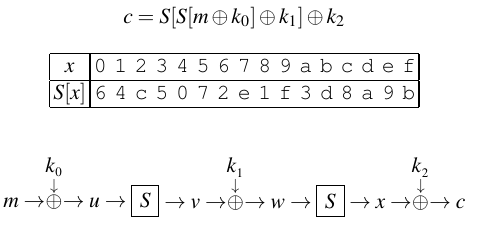

In [22]:
def cipher_two(m: int, k0: int, k1: int, k2: int, S: list) -> int:
    c = S[S[m ^ k0] ^ k1] ^ k2
    return c

In [32]:
S = [6, 4, 0xC, 5, 0, 7, 2, 0xE, 1, 0xF, 3, 0xD, 8, 0xA, 9, 0xB]
S_ = inverse_sbox(S)

ddt = difference_distribution_table(S)

In [33]:
# Looking at our ddt table let's take the following path:
alpha0 = 0xF
alpha1 = 0xD
alpha2 = 0xC

ddt2 = np.matrix(ddt) @ np.matrix(ddt)
p = ddt2[alpha0, alpha2] / 16**2
print(p)

0.25


In [34]:
k0 = getrandbits(4)
k1 = getrandbits(4)
k2 = getrandbits(4)
# Let's spawn some messages and see if the characteristic holds
N = 50000
t = 0
delta_in = alpha0  # input difference
delta_out = alpha2  # output difference

for _ in range(N):
    m = getrandbits(4)
    m_ = m ^ delta_in
    c = cipher_two(m, k0, k1, k2, S)
    c_ = cipher_two(m_, k0, k1, k2, S)
    if c ^ c_ == delta_out:
        t += 1

print(t / N, p)

0.2507 0.25


## Recovering the key

Recovering the key is a guessing process

1. Find a good characteristic with a probability $p \gg \dfrac 1 {2^{\text{block size}}}$
2. Query around $\dfrac 1 p$ chosen pairs $(m, m') \to (c, c')$
3. Decrypt 1 round with every key
4. Set a counter for each key. If we get $\Delta out$ then increment the counter


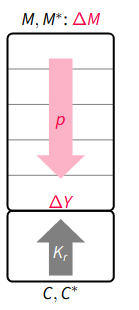

Let's break cipher two

In [41]:
S = [6, 4, 0xC, 5, 0, 7, 2, 0xE, 1, 0xF, 3, 0xD, 8, 0xA, 9, 0xB]
S_ = inverse_sbox(S)

delta_in = 0xF
delta_out = 0xD

In [45]:
def diff_attack(M_list: list, C_list: list, delta_out: list, S_: list, key_bits: int = 4) -> list:
    ts = [0] * (2**key_bits) # count for each possible key
    for k in range(2**key_bits):
        for (m, m_), (c, c_) in zip(M_list, C_list):
            if S_[c ^ k] ^ S_[c_ ^ k] == delta_out:
                ts[k] += 1
    return ts

In [46]:
k0 = getrandbits(4)
k1 = getrandbits(4)
k2 = getrandbits(4)

# Generate message pairs
M_list = []  # List of tuples
C_list = []  # list of tuples

t = 0
N = 100000
for _ in range(N):
    m = getrandbits(4)
    m_ = m ^ delta_in
    c = cipher_two(m, k0, k1, k2, S)
    c_ = cipher_two(m_, k0, k1, k2, S)

    M_list.append((m, m_))
    C_list.append((c, c_))

In [47]:
ts = diff_attack(M_list, C_list, 0xD, S_)
print(k2, np.argmax(ts))

0 0


Let's look at the next example:


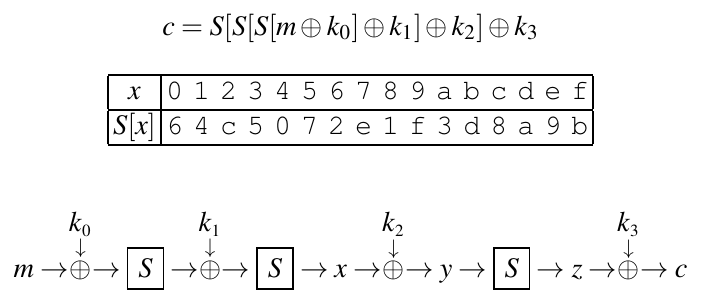

In [48]:
def cipher_three(m, k0, k1, k2, k3, S):
    c = S[S[S[m ^ k0] ^ k1] ^ k2] ^ k3
    return c

In [49]:
S = [6, 4, 0xC, 5, 0, 7, 2, 0xE, 1, 0xF, 3, 0xD, 8, 0xA, 9, 0xB]
S_ = inverse_sbox(S)

ddt = difference_distribution_table(S)

p = np.matrix(ddt) @ np.matrix(ddt) / 16**2

In [50]:
p[2, 2]  # seems like a good entry

0.28125

In [51]:
delta_in = 0xF
delta_out = 0xC

In [54]:
k0 = getrandbits(4)
k1 = getrandbits(4)
k2 = getrandbits(4)
k3 = getrandbits(4)
# Generate message pairs
M_list = []  # List of tuples
C_list = []  # list of tuples

t = 0
N = 100000
for _ in range(N):
    m = getrandbits(4)
    m_ = m ^ delta_in
    c = cipher_three(m, k0, k1, k2, k3, S)
    c_ = cipher_three(m_, k0, k1, k2, k3, S)

    M_list.append((m, m_))
    C_list.append((c, c_))

In [55]:
ts = diff_attack(M_list, C_list, 0xC, S_)
print(k3, np.argmax(ts))

3 3


## Defense against differential cryptanalysis

**The branch number**
> $\mathcal{B}$ is the minimum number of active S-boxes in 2 consecutive rounds

- We want a bigger number $\mathcal{B} = 1 + \text{num of sboxes per round}$
- The more branches we have the lower the probability of a differential to propagate

# Resources

- https://www.iaik.tugraz.at/course/cryptanalysis-705068-sommersemester-2021/
- Block cipher companion
- http://www.cs.bc.edu/~straubin/crypto2017/heys.pdf
- https://www.youtube.com/watch?v=ONhPfIABxFs&t=1s
- https://www.youtube.com/watch?v=Epb5h13S6-Q - FEAL